In [0]:
from pathlib import Path
# import pandas as pd
# import cv2
import os
import numpy as np
# import random
import matplotlib.pyplot as plt
import spacy
# import string
# import re
from spacy.symbols import ORTH
from collections import Counter

%matplotlib inline

In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as tt
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence

In [3]:
!mkdir coco
!wget http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip -P ./coco/ 
!wget http://images.cocodataset.org/zips/train2014.zip -P ./coco/ 
!wget http://images.cocodataset.org/zips/val2014.zip -P ./coco/

mkdir: cannot create directory ‘coco’: File exists
--2020-05-21 00:01:36--  http://msvocds.blob.core.windows.net/annotations-1-0-3/captions_train-val2014.zip
Resolving msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)... 52.176.224.96
Connecting to msvocds.blob.core.windows.net (msvocds.blob.core.windows.net)|52.176.224.96|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19673183 (19M) [application/octet-stream Charset=UTF-8]
Saving to: ‘./coco/captions_train-val2014.zip’

captions_train-val2 100%[===================>]  18.76M  12.6MB/s    in 1.5s    

2020-05-21 00:01:38 (12.6 MB/s) - ‘./coco/captions_train-val2014.zip’ saved [19673183/19673183]

--2020-05-21 00:01:39--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.9.219
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.9.219|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 

In [0]:
from pycocotools.coco import COCO
import json
from PIL import Image
from zipfile import ZipFile

In [0]:
path = Path("coco")
train_ann = path/"annotations/captions_train2014.json"
val_ann = path/"annotations/captions_val2014.json"

In [0]:
from zipfile import ZipFile
# for f in ['captions_train-val2014.zip', 'train2014.zip', 'val2014.zip']:
def extract_zip(filename):
    with ZipFile(path/filename, 'r') as archive:
        archive.extractall(path)

In [0]:
extract_zip('captions_train-val2014.zip')
!rm -rf coco/captions_train-val2014.zip

extract_zip('train2014.zip')
!rm -rf coco/train2014.zip

extract_zip('val2014.zip')
!rm -rf coco/val2014.zip

In [8]:
coco=COCO(train_ann)
coco

loading annotations into memory...
Done (t=2.38s)
creating index...
index created!


In [9]:
train_ids = coco.getImgIds()
train_ids[:10]

[57870, 384029, 222016, 520950, 69675, 547471, 122688, 392136, 398494, 90570]

In [10]:
img_id = train_ids[0]
annIds = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(annIds)
print(train_ids[0])
anns

57870


[{'caption': 'A restaurant has modern wooden tables and chairs.',
  'id': 787980,
  'image_id': 57870},
 {'caption': 'A long restaurant table with rattan rounded back chairs.',
  'id': 789366,
  'image_id': 57870},
 {'caption': 'a long table with a plant on top of it surrounded with wooden chairs ',
  'id': 789888,
  'image_id': 57870},
 {'caption': 'A long table with a flower arrangement in the middle for meetings',
  'id': 791316,
  'image_id': 57870},
 {'caption': 'A table is adorned with wooden chairs with blue accents.',
  'id': 794853,
  'image_id': 57870}]

In [11]:
type(anns), type(anns[0])

(list, dict)

In [12]:
file = coco.loadImgs(img_id)[0]['file_name']
file

'COCO_train2014_000000057870.jpg'

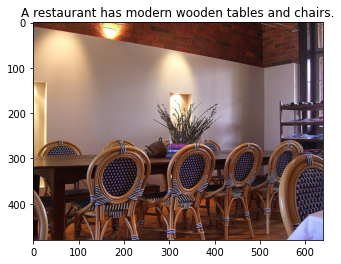

In [13]:
p = path/"train2014"/file
im = Image.open(p)
plt.imshow(im)
plt.title(anns[0]['caption']);

In [14]:
im.size, im.mode

((640, 480), 'RGB')

In [0]:
import gc
gc.collect();

## Data Augmentation

In [0]:
crop = tt.CenterCrop(250)
rcrop = tt.RandomCrop(250)
rot = tt.RandomRotation(20)
flip = tt.RandomHorizontalFlip(p=0.5)
resize = tt.Resize(int(250 * 1.05))

In [0]:
tt.RandomRotation?

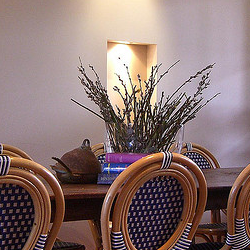

In [18]:
# center crop
crop(im)

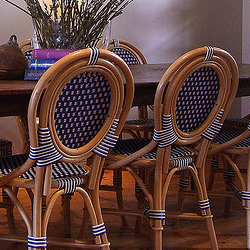

In [19]:
# random crop
rcrop(im)

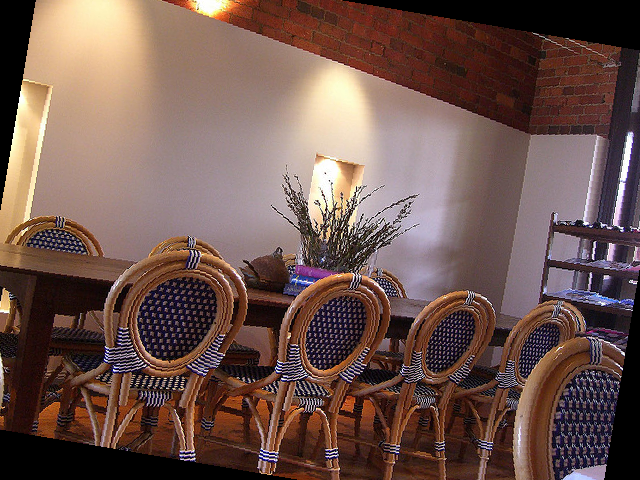

In [20]:
# random rotation: -20 to 20
rot(im)

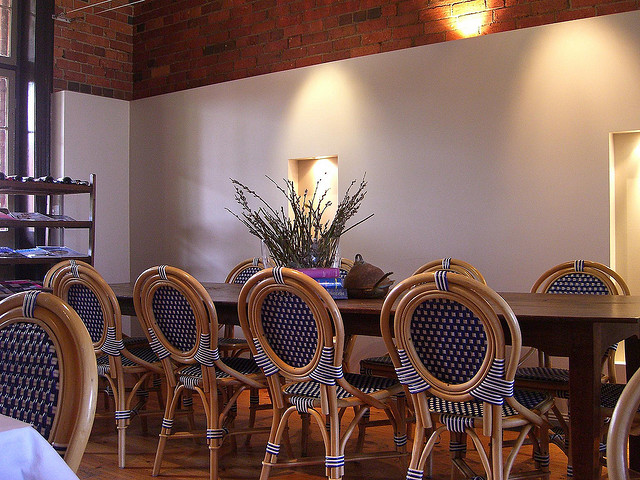

In [21]:
# flip with a probability of 50%
flip(im)

In [0]:
import glob

In [23]:
trn_files = glob.glob('coco/train2014/*')
val_files = glob.glob('coco/val2014/*')
len(trn_files), len(val_files)

(82783, 40504)

In [0]:
for file in trn_files:
    im = Image.open(file)
    im = crop(im)
    im.save(file)

In [0]:
for file in val_files:
    im = Image.open(file)
    im = crop(im)
    im.save(file)

In [26]:
trn_files[0]

'coco/train2014/COCO_train2014_000000234997.jpg'

## Building a vocabulary

In [0]:
import pickle

In [0]:
my_tok = spacy.load('en')
def spacy_tok(x): return [tok.text for tok in my_tok.tokenizer(x)]

In [29]:
x = my_tok.tokenizer("This is a random sentence")
for tok in x:
    print(tok.text)

This
is
a
random
sentence


In [30]:
coco = COCO(train_ann)
annIds = list(coco.anns.keys())
caption = coco.anns[annIds[0]]['caption']
spacy_tok(caption.lower())

loading annotations into memory...
Done (t=1.05s)
creating index...
index created!


['a', 'very', 'clean', 'and', 'well', 'decorated', 'empty', 'bathroom']

In [0]:
def create_vocab(min_count = 2):
    counts = Counter()
    for cap_id in annIds:
        caption = coco.anns[cap_id]['caption']
        counts.update(spacy_tok(caption.lower()))
    print(f"Found a vocabulary of length {len(list(counts))}")

    for word in list(counts):
        if counts[word] < 5:
            # print(f"Deleting word {word}")
            del counts[word]
    print(f"Removed words with count less than 5. Final length {len(list(counts))}")
    return counts

In [32]:
counts = create_vocab()

Found a vocabulary of length 23474
Removed words with count less than 5. Final length 8787


In [0]:
# stores a mapping from words in our vocab to their respective indexes
vocab2index = {"":0, "UNK":1, "<start>":2, "<end>": 3}
words = ["", "UNK", "<start>", "<end>"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [0]:
with open(path/'vocab2index.pickle', 'wb') as handle:
    pickle.dump(vocab2index, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [0]:
def encode_sentence(caption, vocab2index):
    x = spacy_tok(str(caption).lower())
    x = np.array([vocab2index.get(w, vocab2index["UNK"]) for w in x])
    x = np.concatenate(([vocab2index["<start>"]], x, [ vocab2index["<end>"]]))
    return x

In [36]:
cap_id = annIds[0]
caption = coco.anns[cap_id]['caption']
print(caption)
encode_sentence(caption, vocab2index)

A very clean and well decorated empty bathroom


array([ 2,  4,  5,  6,  7,  8,  9, 10, 11,  3])

In [0]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
# import cv2

imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])

def normalize(im, stats=imagenet_stats):
    """Normalizes images with Imagenet stats."""
    return (im - stats[0])/stats[1]

class CocoDataset(Dataset):
    def __init__(self, path, json, vocab, transform=True, sz=250):
        self.path = path
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = tt.Compose([resize, rcrop, rot, flip])
        self.sz = sz
        
    def __getitem__(self, index):
        ann_id = self.ids[index]
        caption = self.coco.anns[ann_id]['caption']
        img_id = self.coco.anns[ann_id]['image_id']
        filename = self.coco.loadImgs(img_id)[0]['file_name']
        # print(filename)
        x = Image.open(self.path/filename)
        if self.transform:
            x = self.transform(x)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return torch.Tensor(x), encode_sentence(caption, self.vocab)
        
    def __len__(self):
        return len(self.ids)

In [0]:
with open(path/'vocab2index.pickle', 'rb') as handle:
    vocab = pickle.load(handle)

In [48]:
len(vocab.keys())

8791

In [49]:
train_ds = CocoDataset(path/"train2014", path/"annotations/captions_train2014.json", vocab)
valid_ds = CocoDataset(path/"val2014", path/"annotations/captions_val2014.json", vocab,
                    transform=False )

loading annotations into memory...
Done (t=0.61s)
creating index...
index created!
loading annotations into memory...
Done (t=1.13s)
creating index...
index created!


In [50]:
x, y = valid_ds[20]
x, y

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [51]:
print(len(train_ds), len(valid_ds)) # 40k valid images

414113 202654


In [0]:
def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    Custom collate_fn for variable length padding. 
    Args:
        data: list of tuple (image, caption). 
            - image: numpy array of shape (3, 250, 250).
            - caption: list of word indexes of variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    # print(data)
    images, captions = zip(*data)
    # print(type(images[1]), type(captions))
    # print("-" * 40)
    # if isinstance(captions, tuple):
    #     images = images[0]
        # captions = captions[0]
        # print(len(images), len(captions))
    # print(images.shape, type(images))

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = torch.Tensor(cap[:end])        
    return images, targets, lengths

In [0]:
trn_dl = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(valid_ds, batch_size=2, shuffle=False, collate_fn=collate_fn)

In [0]:
# next(iter(trn_dl))

In [0]:
from torchvision.models import resnet18

In [0]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained a resnet model and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet18(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, x):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            x = self.resnet(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.bn(self.linear(x))
        return x

In [0]:
images, captions, lengths = next(iter(trn_dl))

In [65]:
embed_size = 100
encoder_model = EncoderCNN(embed_size).cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [66]:
encoder_model(images.cuda()).shape

torch.Size([2, 100])

In [0]:
vocab_size = len(vocab.keys())

In [0]:
embed = nn.Embedding(vocab_size, embed_size)

In [0]:
images, captions, lengths = next(iter(trn_dl))

In [70]:
embeddings = embed(captions.long())
embeddings.shape

torch.Size([2, 14, 100])

In [71]:
images.shape

torch.Size([2, 3, 250, 250])

In [0]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [0]:
embed_size = 100
hidden_size = 512
num_layers = 1
batch_size = 128

In [0]:
encoder = EncoderCNN(embed_size).cuda()
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).cuda()
    
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

In [0]:
trn_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(valid_ds, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [0]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [0]:
def train(trn_dl, num_epochs=10):
    total_step = len(train_ds)
    for epoch in range(num_epochs):
        total_loss = 0
        for i, (images, captions, lengths) in enumerate(trn_dl):
            
            # Set mini-batch dataset
            images = images.cuda()
            captions = captions.cuda()
            targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]
            
            # Forward, backward and optimize
            features = encoder(images)
            outputs = decoder(features, captions, lengths)
            loss = criterion(outputs, targets)
            decoder.zero_grad()
            encoder.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        save_model(encoder, PATH/"encoder-tmp.pth")
        save_model(decoder, PATH/"decoder-tmp.pth")
        print(total_loss/total_step)

In [78]:
train(trn_dl, num_epochs=10)

ValueError: ignored